# Сегментация изображений

![](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Typical_cnn.png/800px-Typical_cnn.png 'r 	Aphex34')


В данном проекте нам предстоит решить задачу сегментации медицинских снимков. В нашем распоряжении датасет [*ADDI project*](https://www.fc.up.pt/addi/ph2%20database.html). В нём содержатся фотографии различных поражений кожи: меланомы и родинок. Однако мы будем заниматься не классификацией, а сегментацией изображений, т.е. разделением изображений на несколько сегментов для упрощения последующего анализа и обработки. Проще говоря, нам необходимо обучить модель, которая сможет для каждого пикселя исходного изображения определить: изображена на нём родинка, либо просто участок кожи.

Попробуем создать и обучить две модели для семантической сегментации:
* [*SegNet*](https://arxiv.org/pdf/1511.00561.pdf), часто используемую на практике модель, базирующуюся на архитектуре *VGG16* для формирования энкодера;
* [*U-Net*](https://arxiv.org/pdf/1505.04597.pdf), модель, изначально создававшуюся и оптимизированную для семантической сегментации медицинских изображений.

В качестве эксперимента реализуем также несколько модификаций оригинальной модели *U-Net*: заменим некоторые слои на их аналоги и посмотрим, скажется ли это на результате.

Также попробуем реализовать несколько функций потерь, чтобы оценить, насколько они влияют на конечный результат сегментации.



In [ ]:
! pip install pytorch-lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 47.4 MB/s eta 0:00:00


In [ ]:
import os

from skimage.io import imread
from skimage.transform import resize

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

from torchvision.transforms.functional import center_crop

import pytorch_lightning as pl

from torchmetrics import JaccardIndex

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (18, 6)})

## Загрузка и подготовка данных

Загрузим датасет и проведём обработку изображений: приведём все фотографии к размеру 256 на 256 пикселей. Разделим данные на обучающую, валидационную и тестовую выборки.

In [ ]:
! wget -q https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

In [ ]:
! unrar x -o+ PH2Dataset.rar -idq

In [ ]:
class SkinDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "PH2Dataset", 
                 batch_size: int = 10):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def setup(self, stage: str):
        images = []
        lesions = []

        for root, dirs, files in os.walk(os.path.join(self.data_dir, 
                                                      'PH2 Dataset images')):
            if root.endswith('_Dermoscopic_Image'):
                images.append(imread(os.path.join(root, files[0])))
            if root.endswith('_lesion'):
                lesions.append(imread(os.path.join(root, files[0])))
        
        size = (256, 256)
        X = [resize(x, size, mode='constant', 
                    anti_aliasing=True) for x in images]
        
        y = [resize(y, size, mode='constant', 
                    anti_aliasing=False) > 0.5 for y in lesions]

        X = np.array(X, np.float32)
        y = np.array(y, np.float32)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=.25)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, 
                                                                              self.y_train, 
                                                                              test_size=.33)

    def train_dataloader(self):
        return DataLoader(list(zip(np.rollaxis(self.X_train, 3, 1), 
                                   self.y_train)),
                          batch_size=self.batch_size, 
                          num_workers=2,
                          pin_memory=True,
                          shuffle=True)

    def val_dataloader(self):
        return DataLoader(list(zip(np.rollaxis(self.X_val, 3, 1), 
                                   self.y_val)), 
                          batch_size=self.batch_size, 
                          num_workers=2,
                          pin_memory=True,
                          shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(list(zip(np.rollaxis(self.X_test, 3, 1), 
                                   self.y_test)), 
                          batch_size=self.batch_size, 
                          num_workers=2,
                          pin_memory=True,
                          shuffle=False)

In [ ]:
data = SkinDataModule()

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

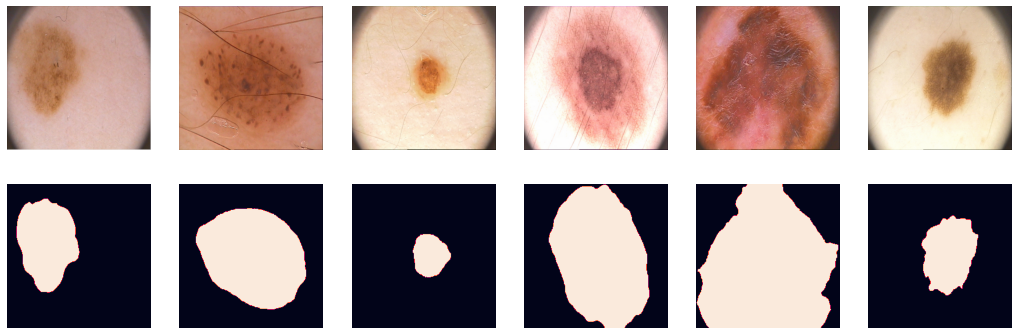

In [ ]:
data.setup(stage=None)

plt.figure(figsize=(18, 6))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(data.X_test[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(data.y_test[i])
plt.show();

Данные готовы, теперь займёмся реализацией архитектур.

## Реализация архитектуры *SegNet*

Будем реализовывать архитектуру SegNet как это описано в статье [*Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). SegNet: A deep convolutional
encoder-decoder architecture for image segmentation*](https://arxiv.org/pdf/1511.00561.pdf). Внесём небольшие изменения, чтобы учесть, что у нас размер картинок — 256 на 256 пикселей. Общая схема архитектуры приведена на рисунке.

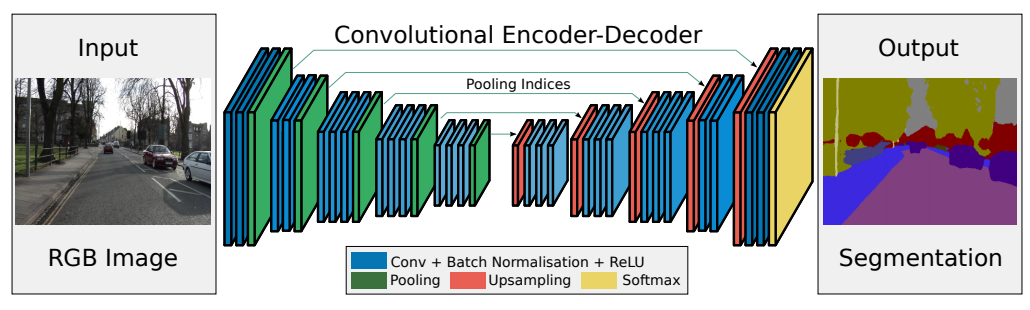

Для оценки качества будем использовать метрику IoU:

$$ IoU=\frac{\text {target} \cap \text { prediction}}{\text {target} \cup \text {prediction} }$$

Пересечение ($A \cap B$) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение ($A \cup B$) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

Так как в рамках задачи планируется проверять работу архитектуры с разными функциями потерь, будем передавать эти функции в качестве одного из аргументов при создании модели.

В качестве первой функции потерь рассмотрим бинарную кросс-энтропию:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
class SegNet(pl.LightningModule):
    def __init__(self, loss=nn.BCEWithLogitsLoss()):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

        self.train_metrics = []
        self.val_metrics = []

        self.loss = loss
        self.metric = JaccardIndex(task='binary')

        self.pool = nn.MaxPool2d(kernel_size=2, 
                                 stride=2, 
                                 return_indices=True)
        
        self.unpool = nn.MaxUnpool2d(kernel_size=2, 
                                     stride=2)
        
        # encoder 
        # block 0
        self.enc_block0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # block1
        self.enc_block1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # block 2
        self.enc_block2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # block 3
        self.enc_block3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # block 4
        self.enc_block4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )

        # decoder
        # block 4
        self.dec_block4 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # block 3
        self.dec_block3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # block 2
        self.dec_block2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # block 1
        self.dec_block1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # block 0
        self.dec_block0 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, 
                      kernel_size=3, padding=1)
        )
    
    def forward(self, input):
        # encoder
        # block 0
        x = self.enc_block0(input)
        x, ind0 = self.pool(x)

        # block 1
        x = self.enc_block1(x)
        x, ind1 = self.pool(x)

        # block 2
        x = self.enc_block2(x)
        x, ind2 = self.pool(x)

        # block 3
        x = self.enc_block3(x)
        x, ind3 = self.pool(x)

        # block 4 
        x = self.enc_block4(x)
        x, ind4 = self.pool(x)

        # decoder
        # block 4
        x = self.unpool(x, ind4)
        x = self.dec_block4(x)

        # block 3
        x = self.unpool(x, ind3)
        x = self.dec_block3(x)

        # block 2
        x = self.unpool(x, ind2)
        x = self.dec_block2(x)

        # block 1
        x = self.unpool(x, ind1)
        x = self.dec_block1(x)

        # block 0
        x = self.unpool(x, ind0)
        x = self.dec_block0(x)
       
        return x
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters())
        scheduler_dict = {
            'scheduler': ReduceLROnPlateau(optimizer,
                                           patience=5),
            'interval': 'epoch', 
            'monitor': 'valid_loss'
            }
        return {'optimizer': optimizer, 
                'lr_scheduler': scheduler_dict}
    
    def _shared_step(self, batch, stage):
        X_batch, y_batch = batch
        
        output = self.forward(X_batch)
        
        loss = self.loss(output.view(-1), y_batch.view(-1))
        preds = torch.round(torch.sigmoid(output))
        iou = self.metric(preds.view(-1), y_batch.view(-1))
        return {'loss': loss,
                'iou': iou}
    
    def _shared_epoch_end(self, outputs, stage):
        loss = np.mean([x['loss'].item() for x in outputs])
        iou = np.mean([x['iou'].item() for x in outputs])

        if stage == 'train':
            self.train_losses.append(loss)
            self.train_metrics.append(iou)
        else:
            self.val_losses.append(loss)
            self.val_metrics.append(iou)
        
        metrics = {f'{stage}_loss': loss,
                   f'{stage}_iou': iou}
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, 'valid')

    def training_epoch_end(self, outputs):
        return self._shared_epoch_end(outputs, 'train')
    
    def validation_epoch_end(self, outputs):
        return self._shared_epoch_end(outputs, 'valid')

In [ ]:
model = SegNet()

In [ ]:
trainer = pl.Trainer(max_epochs=40, accelerator='gpu')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name       | Type               | Params
---------------------------------------------------
0  | loss       | BCEWithLogitsLoss  | 0     
1  | metric     | BinaryJaccardIndex | 0     
2  | pool       | MaxPool2d          | 0     
3  | unpool     | MaxUnpool2d        | 0     
4  | enc_block0 | Sequential         | 39.0 K
5  | enc_block1 | Sequential         | 221 K 
6  | enc_block2 | Sequential         | 1.5 M 
7  | enc_block3 | Sequential         | 5.9 M 
8  | enc_block4 | Sequential         | 23.6 M
9  | dec_block4 | Sequential         | 23.6 M
10 | dec_block3 | Sequential         | 5.9 M 
11 | dec_block2 | Sequential         | 1.5 M 
12 | dec_block1 | Sequential         | 221 K 
13 | dec_block0 | Sequential         | 37.6 K
---------------------------------------------------
62.5 M    Trainable params
0         Non-trainable params
62.5 M    Total p

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
torch.save(model.state_dict(), 'segnet-bce.pt')

Модель обучилась, посмотрим, как менялись значения функций потерь и метрик.

In [ ]:
losses = pd.DataFrame({'train los': model.train_losses,
                       'val los': model.val_losses[1:]})

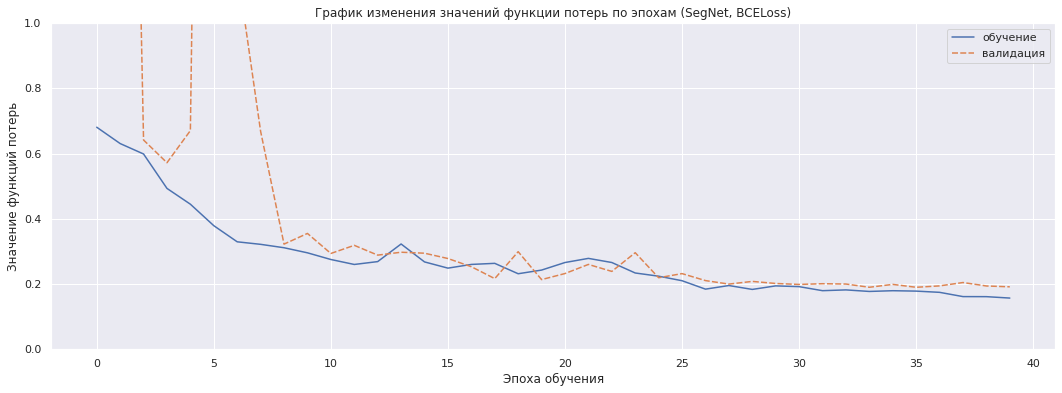

In [ ]:
g = sns.lineplot(data=losses)
g.set(title='График изменения значений функции потерь по эпохам (SegNet, BCELoss)',
      xlabel='Эпоха обучения',
      ylabel='Значение функций потерь')
g.set(ylim=(0, 1))
g.legend(['обучение', 'валидация']);

In [ ]:
metrics = pd.DataFrame({'train iou': model.train_metrics,
                       'val iou': model.val_metrics[1:]})

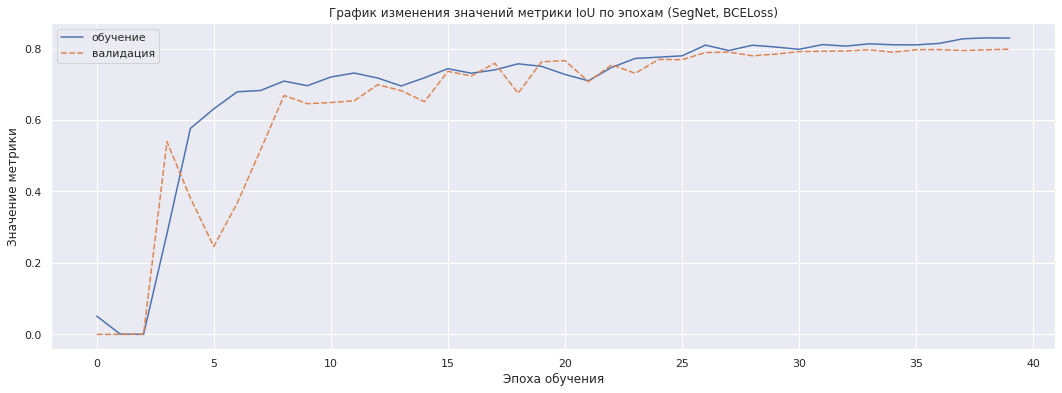

In [ ]:
g = sns.lineplot(data=metrics)
g.set(title='График изменения значений метрики IoU по эпохам (SegNet, BCELoss)',
      xlabel='Эпоха обучения',
      ylabel='Значение метрики')
#g.set(ylim=(0, 1))
g.legend(['обучение', 'валидация']);  

In [ ]:
trainer.logged_metrics

{'valid_loss': tensor(0.1913, dtype=torch.float64),
 'valid_iou': tensor(0.7981, dtype=torch.float64),
 'train_loss': tensor(0.1568, dtype=torch.float64),
 'train_iou': tensor(0.8291, dtype=torch.float64)}

Посмотрим, какие предсказания выдаёт наша модель.

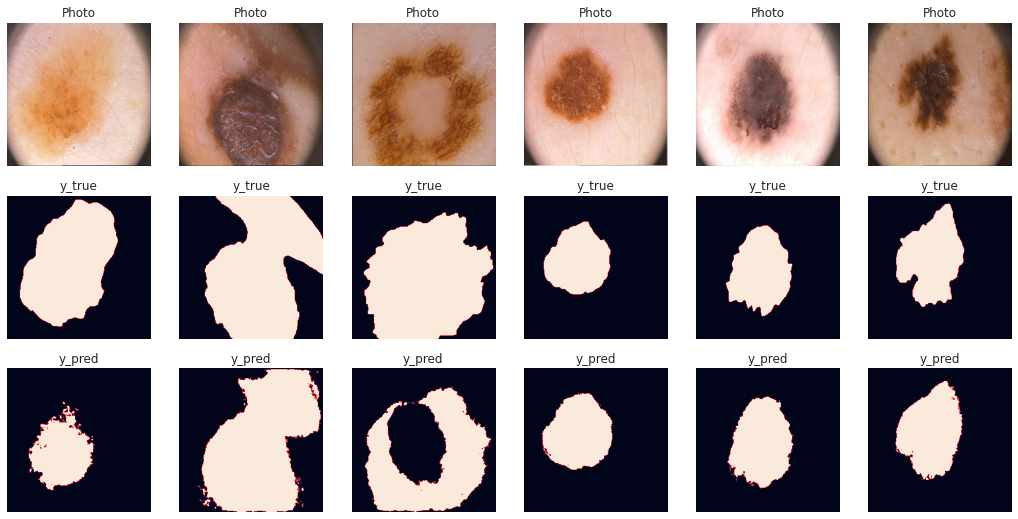

In [ ]:
plt.figure(figsize=(18, 9))

model.eval()
with torch.no_grad():
    X_batch, y_batch = next(iter(data.test_dataloader()))
    
    output = model.forward(X_batch)
    preds = torch.round(torch.sigmoid(output))
    X_batch = np.moveaxis(X_batch.cpu().numpy(), 1, 3)
    #y_batch = np.moveaxis(y_batch.cpu().numpy(), 1, 3)
    preds = np.moveaxis(preds.cpu().numpy(), 1, 3)
    
    for image_no in range(6):
        plt.subplot(3, 6, image_no + 1)
        plt.axis('off')
        plt.imshow(X_batch[image_no])
        plt.title('Photo')

        plt.subplot(3, 6, image_no + 7)
        plt.axis('off')
        plt.imshow(y_batch.cpu().numpy()[image_no])
        plt.title('y_true')

        plt.subplot(3, 6, image_no + 13)
        plt.axis('off')
        plt.imshow(preds[image_no][:, :, 0])
        plt.title('y_pred')

### Дополнительные функции потерь

Теперь попробуем определить ещё несколько функций потерь и посмотрим, как модель будет учиться с ними.

#### Dice Loss

Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Также не забудем подумать о численной нестабильности, возникающей в математической формуле, чтобы учесть этот эффект добавим небольшую поправку.

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2 * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [ ]:
model = SegNet(loss=DiceLoss())

In [ ]:
trainer = pl.Trainer(max_epochs=40, accelerator='gpu')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name       | Type               | Params
---------------------------------------------------
0  | loss       | DiceLoss           | 0     
1  | metric     | BinaryJaccardIndex | 0     
2  | pool       | MaxPool2d          | 0     
3  | unpool     | MaxUnpool2d        | 0     
4  | enc_block0 | Sequential         | 39.0 K
5  | enc_block1 | Sequential         | 221 K 
6  | enc_block2 | Sequential         | 1.5 M 
7  | enc_block3 | Sequential         | 5.9 M 
8  | enc_block4 | Sequential         | 23.6 M
9  | dec_block4 | Sequential         | 23.6 M
10 | dec_block3 | Sequential         | 5.9 M 
11 | dec_block2 | Sequential         | 1.5 M 
12 | dec_block1 | Sequential         | 221 K 
13 | dec_block0 | Sequential         | 37.6 K
---------------------------------------------------
62.5 M    Trainable params
0         Non-trainable params
62.5 M    Total p

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
torch.save(model.state_dict(), 'segnet-dice.pt')

Модель обучилась, посмотрим, как менялись значения функций потерь и метрик.

In [ ]:
losses = pd.DataFrame({'train los': model.train_losses,
                       'val los': model.val_losses[1:]})

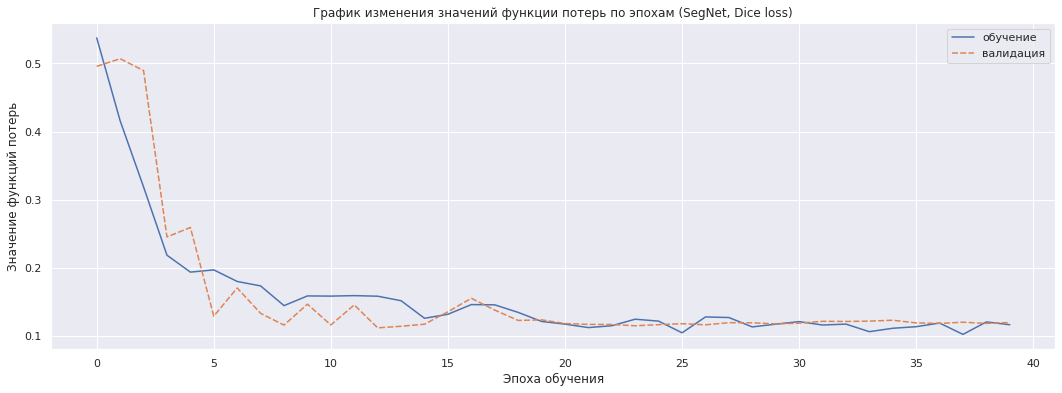

In [ ]:
g = sns.lineplot(data=losses)
g.set(title='График изменения значений функции потерь по эпохам (SegNet, Dice loss)',
      xlabel='Эпоха обучения',
      ylabel='Значение функций потерь')
#g.set(ylim=(0, 1))
g.legend(['обучение', 'валидация']);

In [ ]:
metrics = pd.DataFrame({'train iou': model.train_metrics,
                       'val iou': model.val_metrics[1:]})

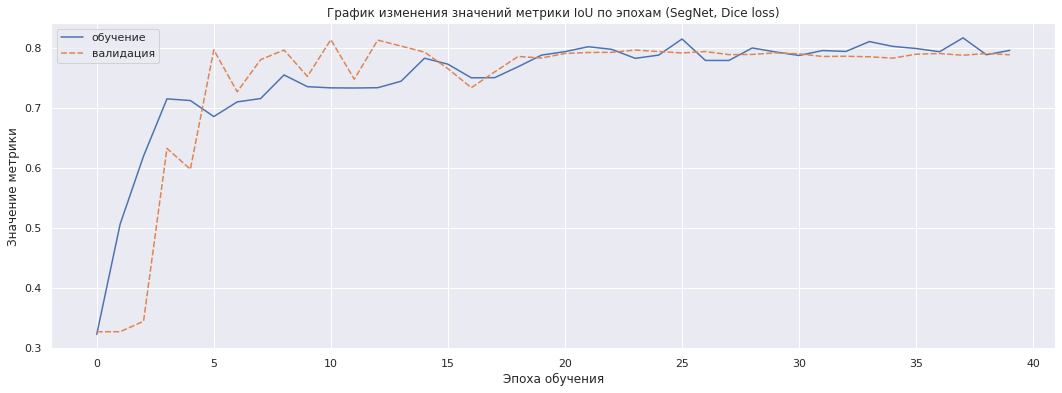

In [ ]:
g = sns.lineplot(data=metrics)
g.set(title='График изменения значений метрики IoU по эпохам (SegNet, Dice loss)',
      xlabel='Эпоха обучения',
      ylabel='Значение метрики')
#g.set(ylim=(0, 1))
g.legend(['обучение', 'валидация']);  

In [ ]:
trainer.logged_metrics

{'valid_loss': tensor(0.1199, dtype=torch.float64),
 'valid_iou': tensor(0.7892, dtype=torch.float64),
 'train_loss': tensor(0.1167, dtype=torch.float64),
 'train_iou': tensor(0.7965, dtype=torch.float64)}

Посмотрим, какие предсказания выдаёт наша модель.

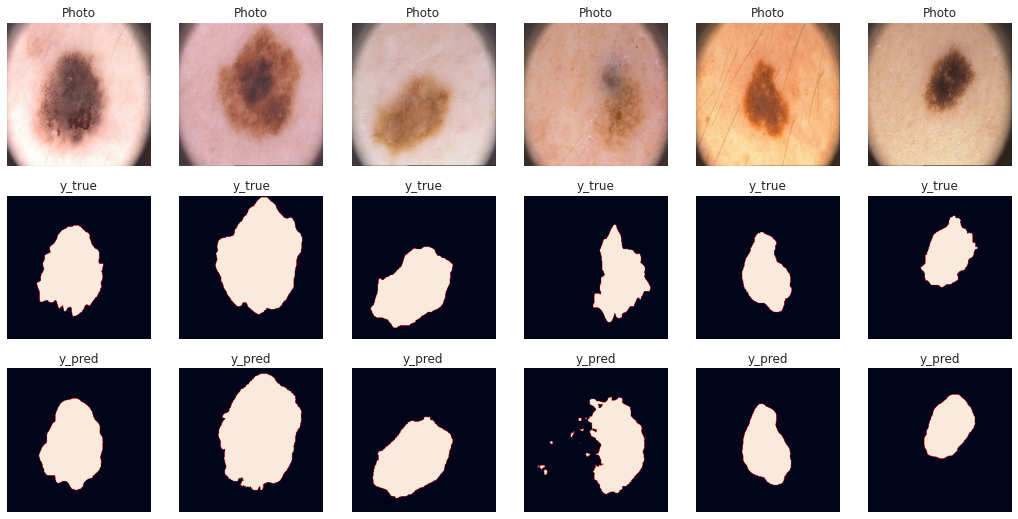

In [ ]:
plt.figure(figsize=(18, 9))

model.eval()
with torch.no_grad():
    X_batch, y_batch = next(iter(data.test_dataloader()))
    
    output = model.forward(X_batch)
    preds = torch.round(torch.sigmoid(output))
    X_batch = np.moveaxis(X_batch.cpu().numpy(), 1, 3)
    #y_batch = np.moveaxis(y_batch.cpu().numpy(), 1, 3)
    preds = np.moveaxis(preds.cpu().numpy(), 1, 3)
    
    for image_no in range(6):
        plt.subplot(3, 6, image_no + 1)
        plt.axis('off')
        plt.imshow(X_batch[image_no])
        plt.title('Photo')

        plt.subplot(3, 6, image_no + 7)
        plt.axis('off')
        plt.imshow(y_batch.cpu().numpy()[image_no])
        plt.title('y_true')

        plt.subplot(3, 6, image_no + 13)
        plt.axis('off')
        plt.imshow(preds[image_no][:, :, 0])
        plt.title('y_pred')

#### Focal Loss

Мы уже пробовали обучать модель с бинарной кросс-энтропией:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой функцией потерь заключается в том, что она имеет тенденцию отдавать предпочтение классу *большинства* (фоновому), а не классу *меньшинства* (переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним [недавним дополнением](https://arxiv.org/pdf/1708.02002.pdf) является взвешенный пиксельный вариант, который взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, eps = 1e-8, gamma = 2):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        loss = -((1 - inputs)**gamma * targets * torch.log(inputs + eps) + 
                 (1 - targets) * torch.log(eps + 1 - inputs)).mean()

        return loss

In [ ]:
model = SegNet(loss=FocalLoss())

In [ ]:
trainer = pl.Trainer(max_epochs=40, accelerator='gpu')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name       | Type               | Params
---------------------------------------------------
0  | loss       | FocalLoss          | 0     
1  | metric     | BinaryJaccardIndex | 0     
2  | pool       | MaxPool2d          | 0     
3  | unpool     | MaxUnpool2d        | 0     
4  | enc_block0 | Sequential         | 39.0 K
5  | enc_block1 | Sequential         | 221 K 
6  | enc_block2 | Sequential         | 1.5 M 
7  | enc_block3 | Sequential         | 5.9 M 
8  | enc_block4 | Sequential         | 23.6 M
9  | dec_block4 | Sequential         | 23.6 M
10 | dec_block3 | Sequential         | 5.9 M 
11 | dec_block2 | Sequential         | 1.5 M 
12 | dec_block1 | Sequential         | 221 K 
13 | dec_block0 | Sequential         | 37.6 K
---------------------------------------------------
62.5 M    Trainable params
0         Non-trainable params
62.5 M    Total p

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
torch.save(model.state_dict(), 'segnet-focal.pt')

Модель обучилась, посмотрим, как менялись значения функций потерь и метрик.

In [ ]:
losses = pd.DataFrame({'train los': model.train_losses,
                       'val los': model.val_losses[1:]})

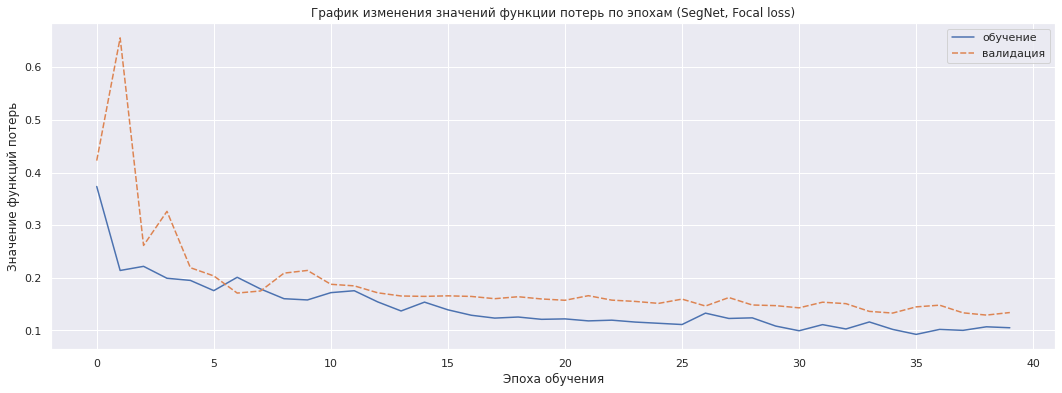

In [ ]:
g = sns.lineplot(data=losses)
g.set(title='График изменения значений функции потерь по эпохам (SegNet, Focal loss)',
      xlabel='Эпоха обучения',
      ylabel='Значение функций потерь')
#g.set(ylim=(0, 1))
g.legend(['обучение', 'валидация']);

In [ ]:
metrics = pd.DataFrame({'train iou': model.train_metrics,
                       'val iou': model.val_metrics[1:]})

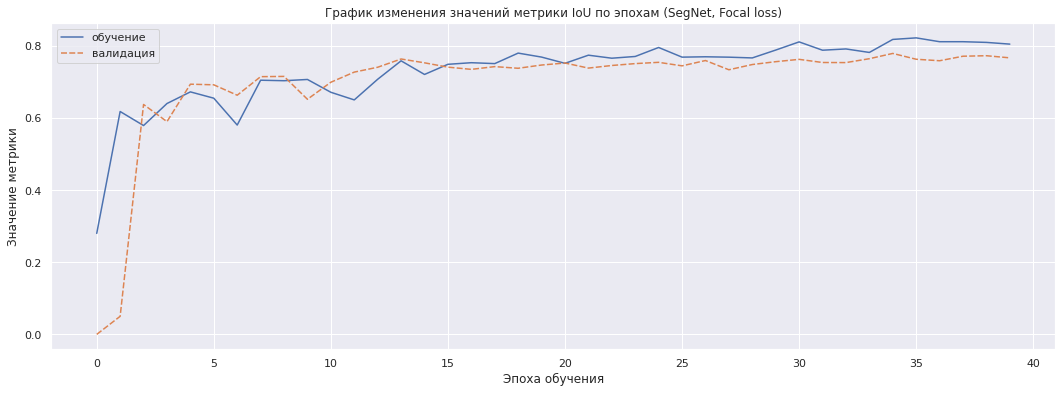

In [ ]:
g = sns.lineplot(data=metrics)
g.set(title='График изменения значений метрики IoU по эпохам (SegNet, Focal loss)',
      xlabel='Эпоха обучения',
      ylabel='Значение метрики')
#g.set(ylim=(0, 1))
g.legend(['обучение', 'валидация']);  

In [ ]:
trainer.logged_metrics

{'valid_loss': tensor(0.1340, dtype=torch.float64),
 'valid_iou': tensor(0.7680, dtype=torch.float64),
 'train_loss': tensor(0.1051, dtype=torch.float64),
 'train_iou': tensor(0.8061, dtype=torch.float64)}

Посмотрим, какие предсказания выдаёт наша модель.

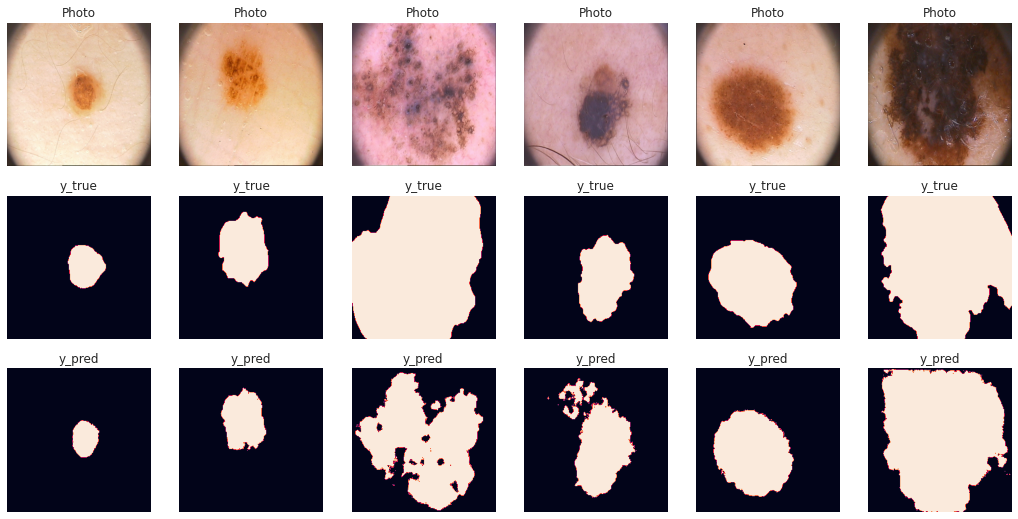

In [ ]:
plt.figure(figsize=(18, 9))

model.eval()
with torch.no_grad():
    X_batch, y_batch = next(iter(data.test_dataloader()))
    
    output = model.forward(X_batch)
    preds = torch.round(torch.sigmoid(output))
    X_batch = np.moveaxis(X_batch.cpu().numpy(), 1, 3)
    #y_batch = np.moveaxis(y_batch.cpu().numpy(), 1, 3)
    preds = np.moveaxis(preds.cpu().numpy(), 1, 3)
    
    for image_no in range(6):
        plt.subplot(3, 6, image_no + 1)
        plt.axis('off')
        plt.imshow(X_batch[image_no])
        plt.title('Photo')

        plt.subplot(3, 6, image_no + 7)
        plt.axis('off')
        plt.imshow(y_batch.cpu().numpy()[image_no])
        plt.title('y_true')

        plt.subplot(3, 6, image_no + 13)
        plt.axis('off')
        plt.imshow(preds[image_no][:, :, 0])
        plt.title('y_pred')

#### WSR Loss

Наконец, реализуем Weakly Supervised Regulatization Loss, предложенный в статье [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1). 

In [ ]:
class WSRLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(WSRLoss, self).__init__()

    def forward(self, inputs, targets, lambd = 0.01, gamma=0.3):
        l_class = nn.BCEWithLogitsLoss()(inputs, targets)

        inputs = inputs.view([-1, 1, 256, 256])

        l_cont = (
            (inputs[:, :, :, 1:] - inputs[:, :, :, :-1]).abs().mean() +
            (inputs[:, :, 1:, :] - inputs[:, :, :-1, :]).abs().mean()
            )

        l_spar = abs(inputs).mean()

        l_fp = l_spar + gamma * l_cont

        return l_class + lambd * l_fp

In [ ]:
model = SegNet(loss=WSRLoss())

In [ ]:
trainer = pl.Trainer(max_epochs=40, accelerator='gpu')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name       | Type               | Params
---------------------------------------------------
0  | loss       | WSRLoss            | 0     
1  | metric     | BinaryJaccardIndex | 0     
2  | pool       | MaxPool2d          | 0     
3  | unpool     | MaxUnpool2d        | 0     
4  | enc_block0 | Sequential         | 39.0 K
5  | enc_block1 | Sequential         | 221 K 
6  | enc_block2 | Sequential         | 1.5 M 
7  | enc_block3 | Sequential         | 5.9 M 
8  | enc_block4 | Sequential         | 23.6 M
9  | dec_block4 | Sequential         | 23.6 M
10 | dec_block3 | Sequential         | 5.9 M 
11 | dec_block2 | Sequential         | 1.5 M 
12 | dec_block1 | Sequential         | 221 K 
13 | dec_block0 | Sequential         | 37.6 K
---------------------------------------------------
62.5 M    Trainable params
0         Non-trainable params
62.5 M    Total p

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
torch.save(model.state_dict(), 'segnet-wsr.pt')

Модель обучилась, посмотрим, как менялись значения функций потерь и метрик.

In [ ]:
losses = pd.DataFrame({'train los': model.train_losses,
                       'val los': model.val_losses[1:]})

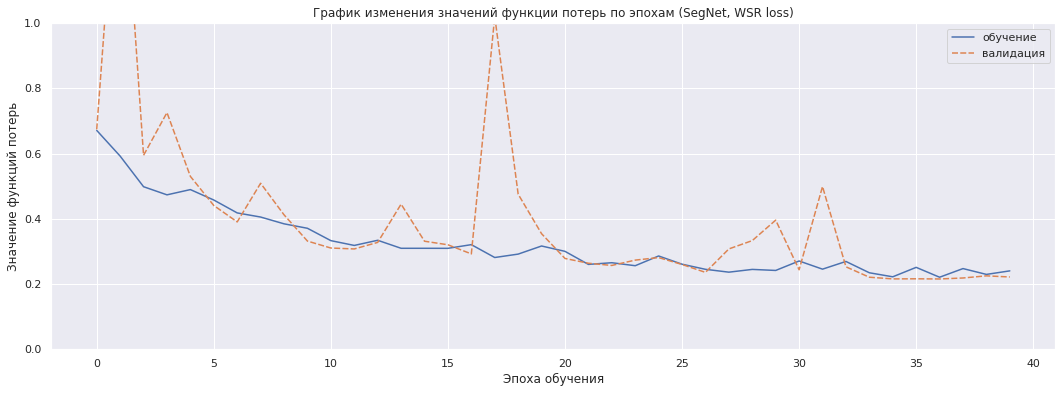

In [ ]:
g = sns.lineplot(data=losses)
g.set(title='График изменения значений функции потерь по эпохам (SegNet, WSR loss)',
      xlabel='Эпоха обучения',
      ylabel='Значение функций потерь')
g.set(ylim=(0, 1))
g.legend(['обучение', 'валидация']);

In [ ]:
metrics = pd.DataFrame({'train iou': model.train_metrics,
                       'val iou': model.val_metrics[1:]})

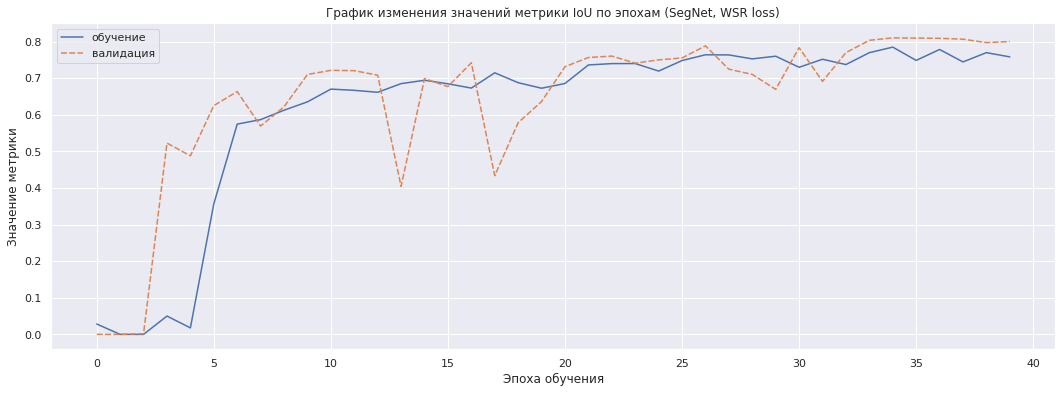

In [ ]:
g = sns.lineplot(data=metrics)
g.set(title='График изменения значений метрики IoU по эпохам (SegNet, WSR loss)',
      xlabel='Эпоха обучения',
      ylabel='Значение метрики')
#g.set(ylim=(0, 1))
g.legend(['обучение', 'валидация']);  

In [ ]:
trainer.logged_metrics

{'valid_loss': tensor(0.2214, dtype=torch.float64),
 'valid_iou': tensor(0.8007, dtype=torch.float64),
 'train_loss': tensor(0.2402, dtype=torch.float64),
 'train_iou': tensor(0.7587, dtype=torch.float64)}

Посмотрим, какие предсказания выдаёт наша модель.

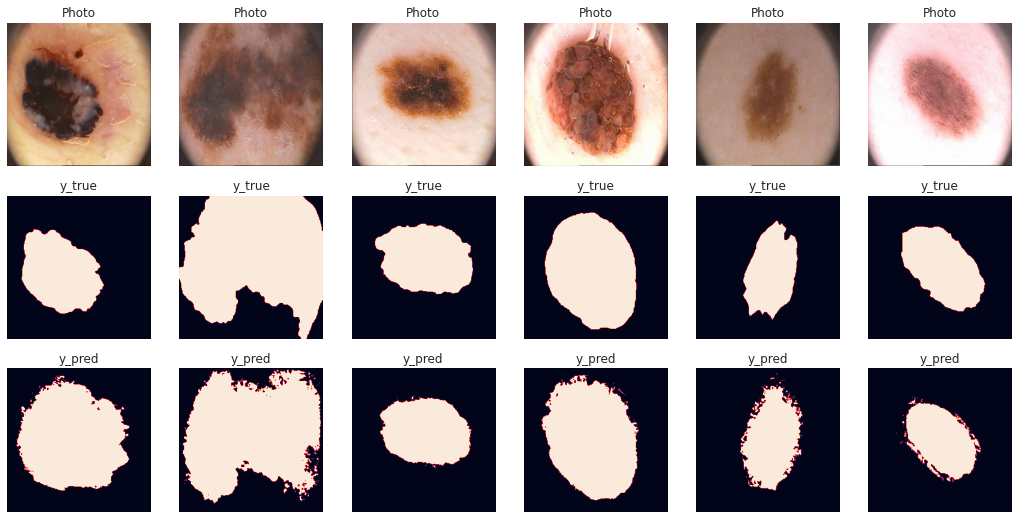

In [ ]:
plt.figure(figsize=(18, 9))

model.eval()
with torch.no_grad():
    X_batch, y_batch = next(iter(data.test_dataloader()))
    
    output = model.forward(X_batch)
    preds = torch.round(torch.sigmoid(output))
    X_batch = np.moveaxis(X_batch.cpu().numpy(), 1, 3)
    #y_batch = np.moveaxis(y_batch.cpu().numpy(), 1, 3)
    preds = np.moveaxis(preds.cpu().numpy(), 1, 3)
    
    for image_no in range(6):
        plt.subplot(3, 6, image_no + 1)
        plt.axis('off')
        plt.imshow(X_batch[image_no])
        plt.title('Photo')

        plt.subplot(3, 6, image_no + 7)
        plt.axis('off')
        plt.imshow(y_batch.cpu().numpy()[image_no])
        plt.title('y_true')

        plt.subplot(3, 6, image_no + 13)
        plt.axis('off')
        plt.imshow(preds[image_no][:, :, 0])
        plt.title('y_pred')

## Реализация архитектуры *U-Net*

Архитектура [*U-Net*](https://arxiv.org/abs/1505.04597) разрабатывалась для семантической сегментации медицинских изображений, но оказалась настолько успешной, что теперь используется и для других задач. Общая схема архитектуре приведена на иллюстрации.

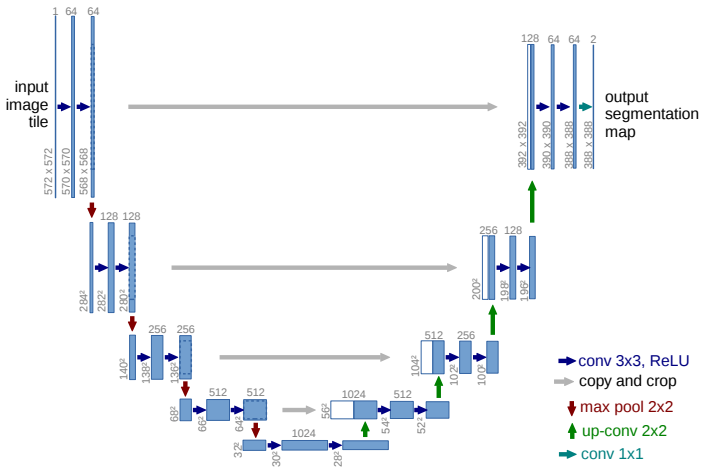

В архитектуре всё так же исползуются энкодер и декодер, но отличительной особеностью данной модели являются *skip-connenctions*, соединяющие части декодера и энкодера. Для реализации *skip-connections* придётся немного пошаманить с реализацией декодера, но ничего страшного. 

В оригинальной архитектуре для улучшения работы сети к оригинальным данным добавлялись отзеркаленная информация с границ изображений. Мы тоже реализуем этот подход с использованием слоя *ReflectionPad*.

In [ ]:
class UNet(pl.LightningModule):
    def __init__(self, loss=nn.BCEWithLogitsLoss()):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

        self.train_metrics = []
        self.val_metrics = []

        self.loss = loss
        self.metric = JaccardIndex(task='binary')

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.reflect = nn.ReflectionPad2d(94)
        
        # encoder 
        # block 0
        self.enc_block0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # block1
        self.enc_block1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # block 2
        self.enc_block2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # block 3
        self.enc_block3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )

        # decoder
        # block 3
        self.dec_upconv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512,
                               kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.dec_block3 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # block 2
        self.dec_upconv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256,
                               kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.dec_block2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # block 1
        self.dec_upconv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128,
                               kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.dec_block1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # block 0
        self.dec_upconv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                               kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.dec_block0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.final_layer = nn.Conv2d(in_channels=64, out_channels=1, 
                                     kernel_size=1, padding=0)
    
    def forward(self, input):
        x = self.reflect(input)

        # encode
        out_e_b0 = self.enc_block0(x) # 444 -> 440
        out_e_pool0 = self.pool(out_e_b0) # 440 -> 220

        out_e_b1 = self.enc_block1(out_e_pool0) # 220 -> 216
        out_e_pool1 = self.pool(out_e_b1) # 216 -> 108

        out_e_b2 = self.enc_block2(out_e_pool1) # 108 -> 104
        out_e_pool2 = self.pool(out_e_b2) # 104 -> 52

        out_e_b3 = self.enc_block3(out_e_pool2) # 52 -> 48
        out_e_pool3 = self.pool(out_e_b3) # 48 -> 24

        # blottleneck
        out_bn = self.bottleneck(out_e_pool3) # 24 -> 20

        # decode
        out_d_upc3 = self.dec_upconv3(out_bn) # 20 -> 40
        out_e_b3 = center_crop(out_e_b3, out_d_upc3.size()[2])
        out_d_b3 = self.dec_block3(torch.cat((out_e_b3, out_d_upc3), dim=1)) # 40 -> 36 

        out_d_upc2 = self.dec_upconv2(out_d_b3) # 36 -> 72
        out_e_b2 = center_crop(out_e_b2, out_d_upc2.size()[2])
        out_d_b2 = self.dec_block2(torch.cat((out_e_b2, out_d_upc2), dim=1)) # 72 -> 68

        out_d_upc1 = self.dec_upconv1(out_d_b2) # 68 -> 136
        out_e_b1 = center_crop(out_e_b1, out_d_upc1.size()[2])
        out_d_b1 = self.dec_block1(torch.cat((out_e_b1, out_d_upc1), dim=1)) # 136 -> 132

        out_d_upc0 = self.dec_upconv0(out_d_b1) # 132 -> 264
        out_e_b0 = center_crop(out_e_b0, out_d_upc0.size()[2])
        out_d_b0 = self.dec_block0(torch.cat((out_e_b0, out_d_upc0), dim=1)) # 264 -> 256

        out = self.final_layer(out_d_b0) # 256 -> 256

        return out
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters())
        scheduler_dict = {
            'scheduler': ReduceLROnPlateau(optimizer,
                                           patience=5),
            'interval': 'epoch', 
            'monitor': 'valid_loss'
            }
        return {'optimizer': optimizer, 
                'lr_scheduler': scheduler_dict}
    
    def _shared_step(self, batch, stage):
        X_batch, y_batch = batch
        
        output = self.forward(X_batch)
        
        loss = self.loss(output.view(-1), y_batch.view(-1))
        preds = torch.round(torch.sigmoid(output))
        iou = self.metric(preds.view(-1), y_batch.view(-1))
        return {'loss': loss,
                'iou': iou}
    
    def _shared_epoch_end(self, outputs, stage):
        loss = np.mean([x['loss'].item() for x in outputs])
        iou = np.mean([x['iou'].item() for x in outputs])

        if stage == 'train':
            self.train_losses.append(loss)
            self.train_metrics.append(iou)
        else:
            self.val_losses.append(loss)
            self.val_metrics.append(iou)
        
        metrics = {f'{stage}_loss': loss,
                   f'{stage}_iou': iou}
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, 'valid')

    def training_epoch_end(self, outputs):
        return self._shared_epoch_end(outputs, 'train')
    
    def validation_epoch_end(self, outputs):
        return self._shared_epoch_end(outputs, 'valid')

In [ ]:
model = UNet()

In [ ]:
trainer = pl.Trainer(max_epochs=40, accelerator='gpu')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name        | Type               | Params
----------------------------------------------------
0  | loss        | BCEWithLogitsLoss  | 0     
1  | metric      | BinaryJaccardIndex | 0     
2  | pool        | MaxPool2d          | 0     
3  | reflect     | ReflectionPad2d    | 0     
4  | enc_block0  | Sequential         | 39.0 K
5  | enc_block1  | Sequential         | 221 K 
6  | enc_block2  | Sequential         | 886 K 
7  | enc_block3  | Sequential         | 3.5 M 
8  | bottleneck  | Sequential         | 14.2 M
9  | dec_upconv3 | Sequential         | 2.1 M 
10 | dec_block3  | Sequential         | 7.1 M 
11 | dec_upconv2 | Sequential         | 525 K 
12 | dec_block2  | Sequential         | 1.8 M 
13 | dec_upconv1 | Sequential         | 131 K 
14 | dec_block1  | Sequential         | 443 K 
15 | dec_upconv0 | Sequential         | 33.0 K
16 | dec_block0  

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
torch.save(model.state_dict(), 'unet.pt')

Модель обучилась, посмотрим, как менялись значения функций потерь и метрик.

In [ ]:
losses = pd.DataFrame({'train los': model.train_losses,
                       'val los': model.val_losses[1:]})

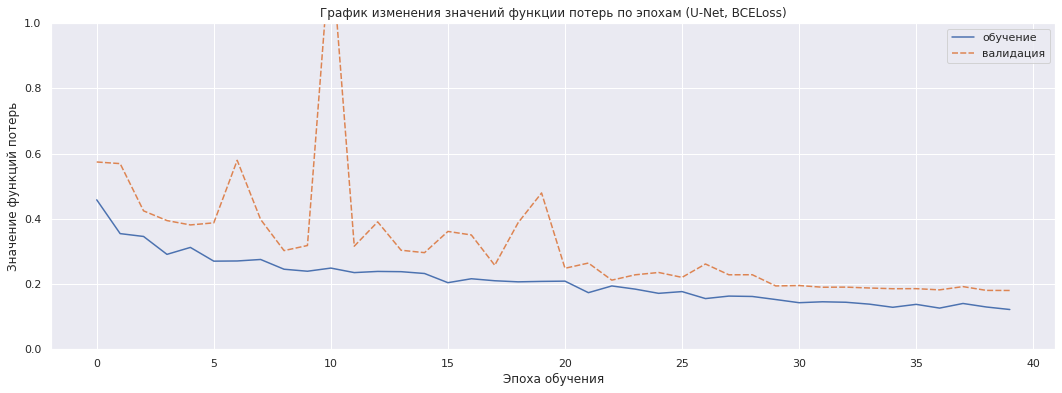

In [ ]:
g = sns.lineplot(data=losses)
g.set(title='График изменения значений функции потерь по эпохам (U-Net, BCELoss)',
      xlabel='Эпоха обучения',
      ylabel='Значение функций потерь')
g.set(ylim=(0, 1))
g.legend(['обучение', 'валидация']);

In [ ]:
metrics = pd.DataFrame({'train iou': model.train_metrics,
                       'val iou': model.val_metrics[1:]})

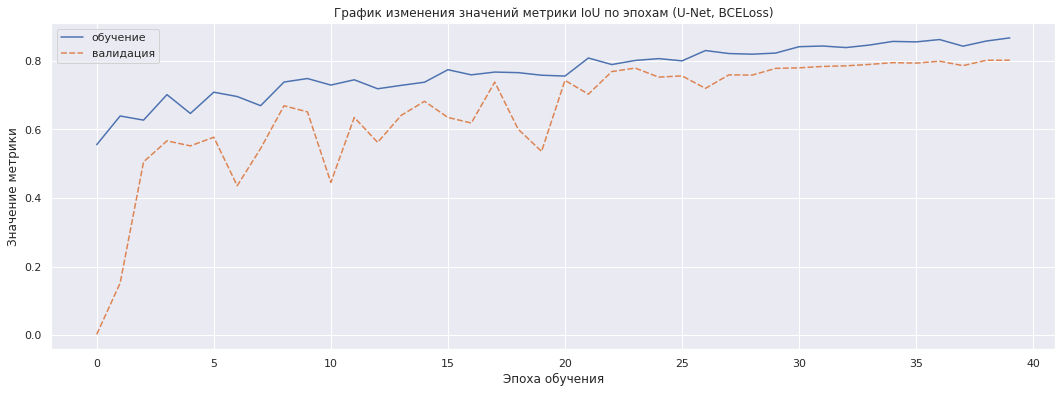

In [ ]:
g = sns.lineplot(data=metrics)
g.set(title='График изменения значений метрики IoU по эпохам (U-Net, BCELoss)',
      xlabel='Эпоха обучения',
      ylabel='Значение метрики')
#g.set(ylim=(0, 1))
g.legend(['обучение', 'валидация']);  

In [ ]:
trainer.logged_metrics

{'valid_loss': tensor(0.1801, dtype=torch.float64),
 'valid_iou': tensor(0.8016, dtype=torch.float64),
 'train_loss': tensor(0.1217, dtype=torch.float64),
 'train_iou': tensor(0.8668, dtype=torch.float64)}

Посмотрим, какие предсказания выдаёт наша модель.

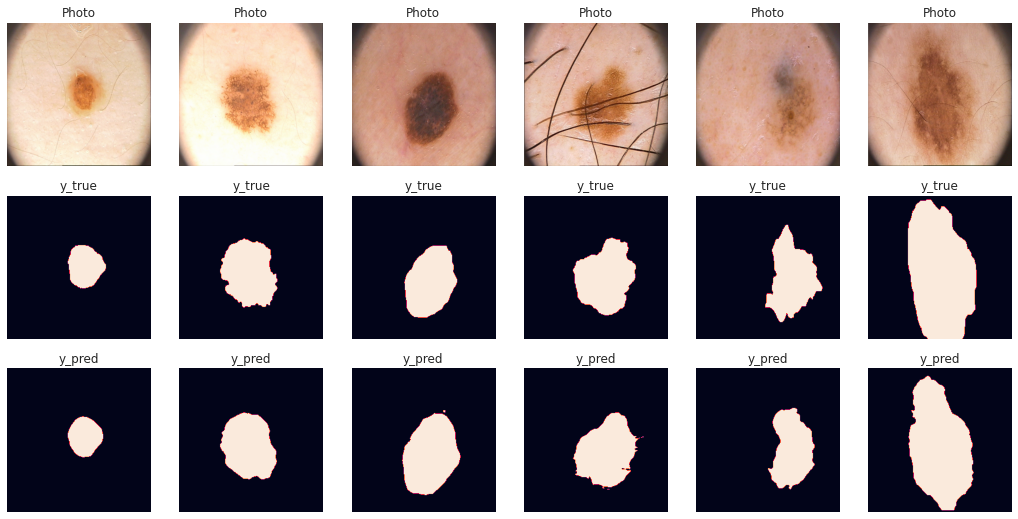

In [ ]:
plt.figure(figsize=(18, 9))

model.eval()
with torch.no_grad():
    X_batch, y_batch = next(iter(data.test_dataloader()))
    
    output = model.forward(X_batch)
    preds = torch.round(torch.sigmoid(output))
    X_batch = np.moveaxis(X_batch.cpu().numpy(), 1, 3)
    #y_batch = np.moveaxis(y_batch.cpu().numpy(), 1, 3)
    preds = np.moveaxis(preds.cpu().numpy(), 1, 3)
    
    for image_no in range(6):
        plt.subplot(3, 6, image_no + 1)
        plt.axis('off')
        plt.imshow(X_batch[image_no])
        plt.title('Photo')

        plt.subplot(3, 6, image_no + 7)
        plt.axis('off')
        plt.imshow(y_batch.cpu().numpy()[image_no])
        plt.title('y_true')

        plt.subplot(3, 6, image_no + 13)
        plt.axis('off')
        plt.imshow(preds[image_no][:, :, 0])
        plt.title('y_pred')

## Модификации *U-Net*

### *U-Net + upsampling*

Реализуем модификацию архитектуры U-Net, в которой для увеличения размера в декодере будем использовать слой *nn.Upsampling*. Посмотрим, как это скажется на обучаемости модели и метриках.

In [ ]:
class UNetUps(pl.LightningModule):
    def __init__(self, loss=nn.BCEWithLogitsLoss()):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

        self.train_metrics = []
        self.val_metrics = []

        self.loss = loss
        self.metric = JaccardIndex(task='binary')

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.reflect = nn.ReflectionPad2d(94)
        
        # encoder 
        # block 0
        self.enc_block0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # block1
        self.enc_block1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # block 2
        self.enc_block2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # block 3
        self.enc_block3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder
        # block 3
        self.dec_upconv3 = nn.Upsample(size=40)

        self.dec_block3 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # block 2
        self.dec_upconv2 = nn.Upsample(size=72)

        self.dec_block2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # block 1
        self.dec_upconv1 = nn.Upsample(size=136)

        self.dec_block1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # block 0
        self.dec_upconv0 = nn.Upsample(size=264)

        self.dec_block0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.final_layer = nn.Conv2d(in_channels=64, out_channels=1, 
                                     kernel_size=1, padding=0)
    
    def forward(self, input):
        x = self.reflect(input)

        # encode
        out_e_b0 = self.enc_block0(x) # 444 -> 440
        out_e_pool0 = self.pool(out_e_b0) # 440 -> 220

        out_e_b1 = self.enc_block1(out_e_pool0) # 220 -> 216
        out_e_pool1 = self.pool(out_e_b1) # 216 -> 108

        out_e_b2 = self.enc_block2(out_e_pool1) # 108 -> 104
        out_e_pool2 = self.pool(out_e_b2) # 104 -> 52

        out_e_b3 = self.enc_block3(out_e_pool2) # 52 -> 48
        out_e_pool3 = self.pool(out_e_b3) # 48 -> 24

        # blottleneck
        out_bn = self.bottleneck(out_e_pool3) # 24 -> 20

        # decode
        out_d_upc3 = self.dec_upconv3(out_bn) # 20 -> 40
        out_e_b3 = center_crop(out_e_b3, out_d_upc3.size()[2])
        out_d_b3 = self.dec_block3(torch.cat((out_e_b3, out_d_upc3), dim=1)) # 40 -> 36 

        out_d_upc2 = self.dec_upconv2(out_d_b3) # 36 -> 72
        out_e_b2 = center_crop(out_e_b2, out_d_upc2.size()[2])
        out_d_b2 = self.dec_block2(torch.cat((out_e_b2, out_d_upc2), dim=1)) # 72 -> 68

        out_d_upc1 = self.dec_upconv1(out_d_b2) # 68 -> 136
        out_e_b1 = center_crop(out_e_b1, out_d_upc1.size()[2])
        out_d_b1 = self.dec_block1(torch.cat((out_e_b1, out_d_upc1), dim=1)) # 136 -> 132

        out_d_upc0 = self.dec_upconv0(out_d_b1) # 132 -> 264
        out_e_b0 = center_crop(out_e_b0, out_d_upc0.size()[2])
        out_d_b0 = self.dec_block0(torch.cat((out_e_b0, out_d_upc0), dim=1)) # 264 -> 256

        out = self.final_layer(out_d_b0) # 256 -> 256

        return out
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters())
        scheduler_dict = {
            'scheduler': ReduceLROnPlateau(optimizer,
                                           patience=5),
            'interval': 'epoch', 
            'monitor': 'valid_loss'
            }
        return {'optimizer': optimizer, 
                'lr_scheduler': scheduler_dict}
    
    def _shared_step(self, batch, stage):
        X_batch, y_batch = batch
        
        output = self.forward(X_batch)
        
        loss = self.loss(output.view(-1), y_batch.view(-1))
        preds = torch.round(torch.sigmoid(output))
        iou = self.metric(preds.view(-1), y_batch.view(-1))
        return {'loss': loss,
                'iou': iou}
    
    def _shared_epoch_end(self, outputs, stage):
        loss = np.mean([x['loss'].item() for x in outputs])
        iou = np.mean([x['iou'].item() for x in outputs])

        if stage == 'train':
            self.train_losses.append(loss)
            self.train_metrics.append(iou)
        else:
            self.val_losses.append(loss)
            self.val_metrics.append(iou)
        
        metrics = {f'{stage}_loss': loss,
                   f'{stage}_iou': iou}
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, 'valid')

    def training_epoch_end(self, outputs):
        return self._shared_epoch_end(outputs, 'train')
    
    def validation_epoch_end(self, outputs):
        return self._shared_epoch_end(outputs, 'valid')

In [ ]:
model = UNetUps()

In [ ]:
trainer = pl.Trainer(max_epochs=40, accelerator='gpu')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name        | Type               | Params
----------------------------------------------------
0  | loss        | BCEWithLogitsLoss  | 0     
1  | metric      | BinaryJaccardIndex | 0     
2  | pool        | MaxPool2d          | 0     
3  | reflect     | ReflectionPad2d    | 0     
4  | enc_block0  | Sequential         | 39.0 K
5  | enc_block1  | Sequential         | 221 K 
6  | enc_block2  | Sequential         | 886 K 
7  | enc_block3  | Sequential         | 3.5 M 
8  | bottleneck  | Sequential         | 9.4 M 
9  | dec_upconv3 | Upsample           | 0     
10 | dec_block3  | Sequential         | 5.9 M 
11 | dec_upconv2 | Upsample           | 0     
12 | dec_block2  | Sequential         | 1.5 M 
13 | dec_upconv1 | Upsample           | 0     
14 | dec_block1  | Sequential         | 369 K 
15 | dec_upconv0 | Upsample           | 0     
16 | dec_block0  

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
torch.save(model.state_dict(), 'unet-ups.pt')

Модель обучилась, посмотрим, как менялись значения функций потерь и метрик.

In [ ]:
losses = pd.DataFrame({'train los': model.train_losses,
                       'val los': model.val_losses[1:]})

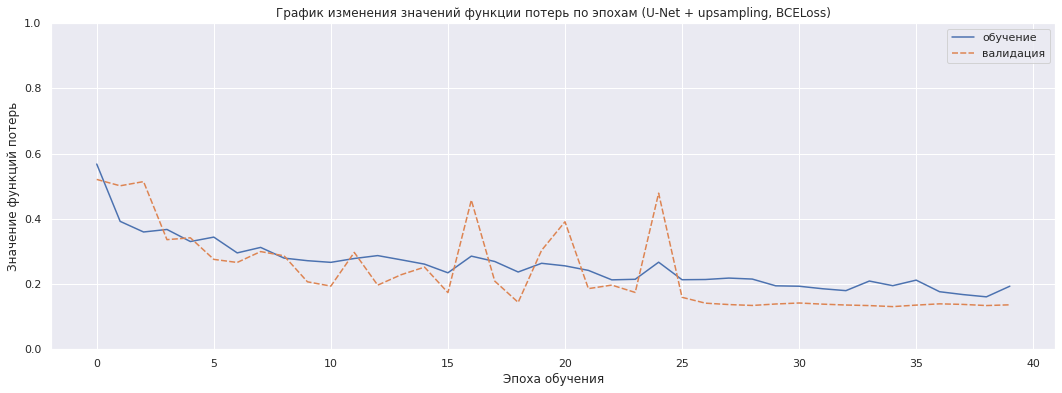

In [ ]:
g = sns.lineplot(data=losses)
g.set(title='График изменения значений функции потерь по эпохам (U-Net + upsampling, BCELoss)',
      xlabel='Эпоха обучения',
      ylabel='Значение функций потерь')
g.set(ylim=(0, 1))
g.legend(['обучение', 'валидация']);

In [ ]:
metrics = pd.DataFrame({'train iou': model.train_metrics,
                       'val iou': model.val_metrics[1:]})

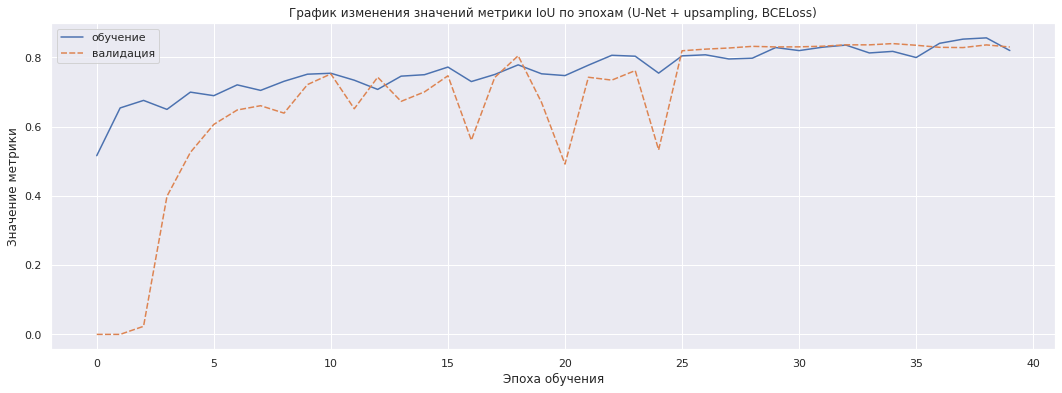

In [ ]:
g = sns.lineplot(data=metrics)
g.set(title='График изменения значений метрики IoU по эпохам (U-Net + upsampling, BCELoss)',
      xlabel='Эпоха обучения',
      ylabel='Значение метрики')
#g.set(ylim=(0, 1))
g.legend(['обучение', 'валидация']);  

In [ ]:
trainer.logged_metrics

{'valid_loss': tensor(0.1361, dtype=torch.float64),
 'valid_iou': tensor(0.8299, dtype=torch.float64),
 'train_loss': tensor(0.1932, dtype=torch.float64),
 'train_iou': tensor(0.8197, dtype=torch.float64)}

Посмотрим, какие предсказания выдаёт наша модель.

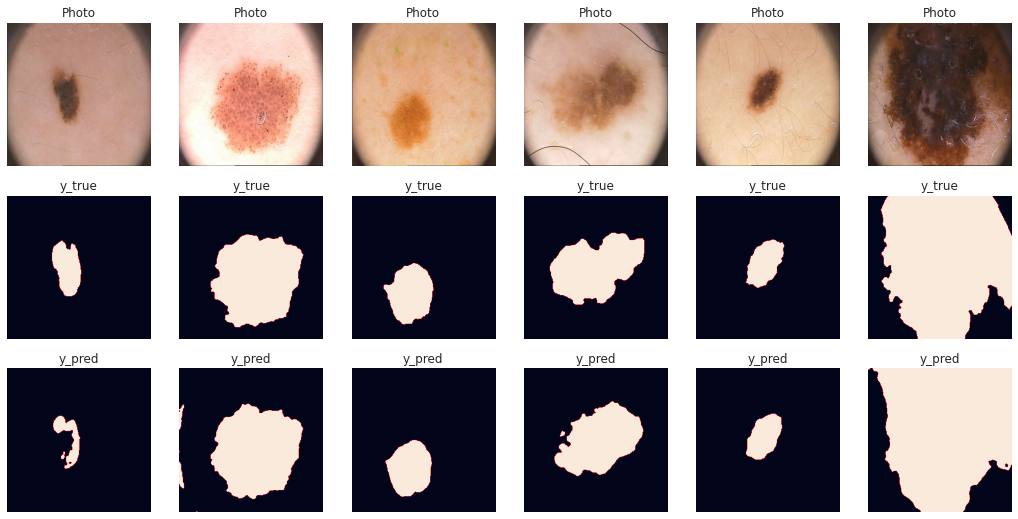

In [ ]:
plt.figure(figsize=(18, 9))

model.eval()
with torch.no_grad():
    X_batch, y_batch = next(iter(data.test_dataloader()))
    
    output = model.forward(X_batch)
    preds = torch.round(torch.sigmoid(output))
    X_batch = np.moveaxis(X_batch.cpu().numpy(), 1, 3)
    #y_batch = np.moveaxis(y_batch.cpu().numpy(), 1, 3)
    preds = np.moveaxis(preds.cpu().numpy(), 1, 3)
    
    for image_no in range(6):
        plt.subplot(3, 6, image_no + 1)
        plt.axis('off')
        plt.imshow(X_batch[image_no])
        plt.title('Photo')

        plt.subplot(3, 6, image_no + 7)
        plt.axis('off')
        plt.imshow(y_batch.cpu().numpy()[image_no])
        plt.title('y_true')

        plt.subplot(3, 6, image_no + 13)
        plt.axis('off')
        plt.imshow(preds[image_no][:, :, 0])
        plt.title('y_pred')

### *U-Net + convpool*

Реализуем модификацию архитектуры U-Net, в которой для уменьшения размера в энкодере заменим *maxpool* на свёрточный слой со *stride=2*. Посмотрим, как это скажется на обучаемости модели и метриках.

In [ ]:
class UNetConv(pl.LightningModule):
    def __init__(self, loss=nn.BCEWithLogitsLoss()):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

        self.train_metrics = []
        self.val_metrics = []

        self.loss = loss
        self.metric = JaccardIndex(task='binary')
        
        self.reflect = nn.ReflectionPad2d(94)
        
        # encoder 
        # block 0
        self.enc_block0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.enc_pool0 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, 
                      kernel_size=2, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # block1
        self.enc_block1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.enc_pool1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, 
                      kernel_size=2, padding=0, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # block 2
        self.enc_block2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.enc_pool2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, 
                      kernel_size=2, padding=0, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # block 3
        self.enc_block3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.enc_pool3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=2, padding=0, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU()
        )

        # decoder
        # block 3
        self.dec_upconv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512,
                               kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.dec_block3 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, 
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # block 2
        self.dec_upconv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256,
                               kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.dec_block2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # block 1
        self.dec_upconv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128,
                               kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.dec_block1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # block 0
        self.dec_upconv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                               kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.dec_block0 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.final_layer = nn.Conv2d(in_channels=64, out_channels=1, 
                                     kernel_size=1, padding=0)
    
    def forward(self, input):
        x = self.reflect(input)

        # encode
        out_e_b0 = self.enc_block0(x) # 444 -> 440
        out_e_pool0 = self.enc_pool0(out_e_b0) # 440 -> 220

        out_e_b1 = self.enc_block1(out_e_pool0) # 220 -> 216
        out_e_pool1 = self.enc_pool1(out_e_b1) # 216 -> 108

        out_e_b2 = self.enc_block2(out_e_pool1) # 108 -> 104
        out_e_pool2 = self.enc_pool2(out_e_b2) # 104 -> 52

        out_e_b3 = self.enc_block3(out_e_pool2) # 52 -> 48
        out_e_pool3 = self.enc_pool3(out_e_b3) # 48 -> 24

        # blottleneck
        out_bn = self.bottleneck(out_e_pool3) # 24 -> 20

        # decode
        out_d_upc3 = self.dec_upconv3(out_bn) # 20 -> 40
        out_e_b3 = center_crop(out_e_b3, out_d_upc3.size()[2])
        out_d_b3 = self.dec_block3(torch.cat((out_e_b3, out_d_upc3), dim=1)) # 40 -> 36 

        out_d_upc2 = self.dec_upconv2(out_d_b3) # 36 -> 72
        out_e_b2 = center_crop(out_e_b2, out_d_upc2.size()[2])
        out_d_b2 = self.dec_block2(torch.cat((out_e_b2, out_d_upc2), dim=1)) # 72 -> 68

        out_d_upc1 = self.dec_upconv1(out_d_b2) # 68 -> 136
        out_e_b1 = center_crop(out_e_b1, out_d_upc1.size()[2])
        out_d_b1 = self.dec_block1(torch.cat((out_e_b1, out_d_upc1), dim=1)) # 136 -> 132

        out_d_upc0 = self.dec_upconv0(out_d_b1) # 132 -> 264
        out_e_b0 = center_crop(out_e_b0, out_d_upc0.size()[2])
        out_d_b0 = self.dec_block0(torch.cat((out_e_b0, out_d_upc0), dim=1)) # 264 -> 256

        out = self.final_layer(out_d_b0) # 256 -> 256

        return out
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters())
        scheduler_dict = {
            'scheduler': ReduceLROnPlateau(optimizer,
                                           patience=5),
            'interval': 'epoch', 
            'monitor': 'valid_loss'
            }
        return {'optimizer': optimizer, 
                'lr_scheduler': scheduler_dict}
    
    def _shared_step(self, batch, stage):
        X_batch, y_batch = batch
        
        output = self.forward(X_batch)
        
        loss = self.loss(output.view(-1), y_batch.view(-1))
        preds = torch.round(torch.sigmoid(output))
        iou = self.metric(preds.view(-1), y_batch.view(-1))
        return {'loss': loss,
                'iou': iou}
    
    def _shared_epoch_end(self, outputs, stage):
        loss = np.mean([x['loss'].item() for x in outputs])
        iou = np.mean([x['iou'].item() for x in outputs])

        if stage == 'train':
            self.train_losses.append(loss)
            self.train_metrics.append(iou)
        else:
            self.val_losses.append(loss)
            self.val_metrics.append(iou)
        
        metrics = {f'{stage}_loss': loss,
                   f'{stage}_iou': iou}
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, 'valid')

    def training_epoch_end(self, outputs):
        return self._shared_epoch_end(outputs, 'train')
    
    def validation_epoch_end(self, outputs):
        return self._shared_epoch_end(outputs, 'valid')

In [ ]:
model = UNetConv()

In [ ]:
trainer = pl.Trainer(max_epochs=40, accelerator='gpu')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name        | Type               | Params
----------------------------------------------------
0  | loss        | BCEWithLogitsLoss  | 0     
1  | metric      | BinaryJaccardIndex | 0     
2  | reflect     | ReflectionPad2d    | 0     
3  | enc_block0  | Sequential         | 39.0 K
4  | enc_pool0   | Sequential         | 16.6 K
5  | enc_block1  | Sequential         | 221 K 
6  | enc_pool1   | Sequential         | 65.9 K
7  | enc_block2  | Sequential         | 886 K 
8  | enc_pool2   | Sequential         | 262 K 
9  | enc_block3  | Sequential         | 3.5 M 
10 | enc_pool3   | Sequential         | 1.1 M 
11 | bottleneck  | Sequential         | 14.2 M
12 | dec_upconv3 | Sequential         | 2.1 M 
13 | dec_block3  | Sequential         | 7.1 M 
14 | dec_upconv2 | Sequential         | 525 K 
15 | dec_block2  | Sequential         | 1.8 M 
16 | dec_upconv1 

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
torch.save(model.state_dict(), 'unet-conv.pt')

Модель обучилась, посмотрим, как менялись значения функций потерь и метрик.

In [ ]:
losses = pd.DataFrame({'train los': model.train_losses,
                       'val los': model.val_losses[1:]})

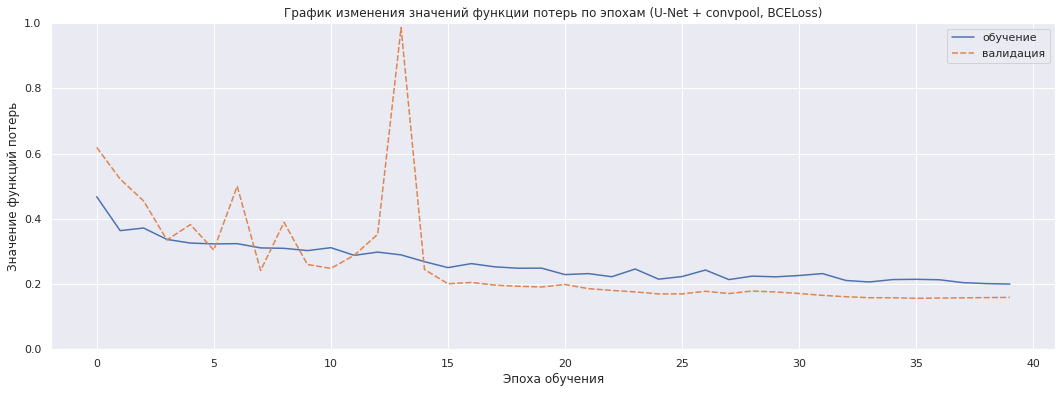

In [ ]:
g = sns.lineplot(data=losses)
g.set(title='График изменения значений функции потерь по эпохам (U-Net + convpool, BCELoss)',
      xlabel='Эпоха обучения',
      ylabel='Значение функций потерь')
g.set(ylim=(0, 1))
g.legend(['обучение', 'валидация']);

In [ ]:
metrics = pd.DataFrame({'train iou': model.train_metrics,
                       'val iou': model.val_metrics[1:]})

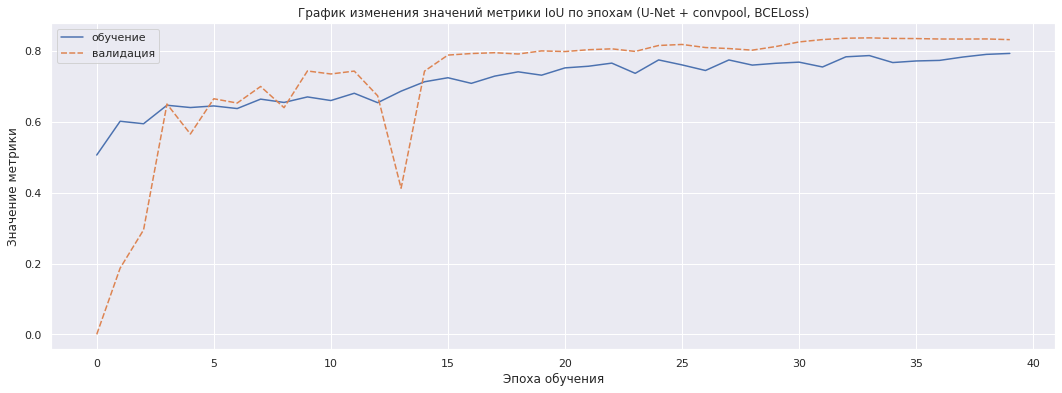

In [ ]:
g = sns.lineplot(data=metrics)
g.set(title='График изменения значений метрики IoU по эпохам (U-Net + convpool, BCELoss)',
      xlabel='Эпоха обучения',
      ylabel='Значение метрики')
#g.set(ylim=(0, 1))
g.legend(['обучение', 'валидация']);  

In [ ]:
trainer.logged_metrics

{'valid_loss': tensor(0.1588, dtype=torch.float64),
 'valid_iou': tensor(0.8327, dtype=torch.float64),
 'train_loss': tensor(0.1997, dtype=torch.float64),
 'train_iou': tensor(0.7938, dtype=torch.float64)}

Посмотрим, какие предсказания выдаёт наша модель.

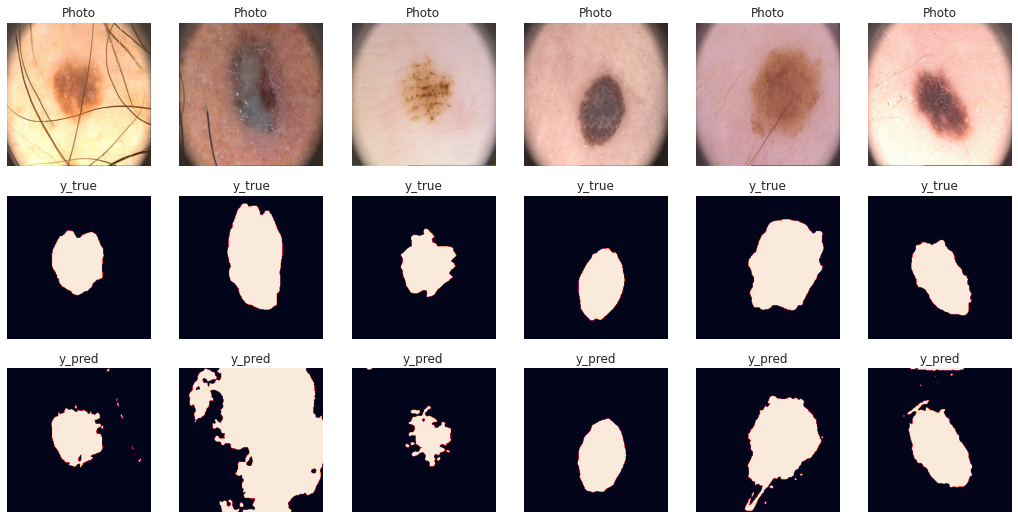

In [ ]:
plt.figure(figsize=(18, 9))

model.eval()
with torch.no_grad():
    X_batch, y_batch = next(iter(data.test_dataloader()))
    
    output = model.forward(X_batch)
    preds = torch.round(torch.sigmoid(output))
    X_batch = np.moveaxis(X_batch.cpu().numpy(), 1, 3)
    #y_batch = np.moveaxis(y_batch.cpu().numpy(), 1, 3)
    preds = np.moveaxis(preds.cpu().numpy(), 1, 3)
    
    for image_no in range(6):
        plt.subplot(3, 6, image_no + 1)
        plt.axis('off')
        plt.imshow(X_batch[image_no])
        plt.title('Photo')

        plt.subplot(3, 6, image_no + 7)
        plt.axis('off')
        plt.imshow(y_batch.cpu().numpy()[image_no])
        plt.title('y_true')

        plt.subplot(3, 6, image_no + 13)
        plt.axis('off')
        plt.imshow(preds[image_no][:, :, 0])
        plt.title('y_pred')

## Вывод

В данном проекте мы решали задачу сегментации медицинских снимков. В нашем распоряжении датасет [*ADDI project*](https://www.fc.up.pt/addi/ph2%20database.html). В нём содержатся фотографии различных поражений кожи: меланомы и родинок.

Мы начали с того, что реализовали модель на основе архитектуры [*SegNet*](https://arxiv.org/pdf/1511.00561.pdf), в качестве функции потерь использовалась бинарную кросс-энтропию. Мы также реализовали несколько дополнительных функций потерь, чтобы проверить, как они скажутся на обучаемости модели.

Каждая модель обучалась в течение 40 эпох с оптимизатором *AdamW*. В качестве метрики мы использовали [коэффициент Жаккара *(IoU)*](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%96%D0%B0%D0%BA%D0%BA%D0%B0%D1%80%D0%B0).

Сведём данные по значениям метрики IoU на последних эпохах обучения для всех функций потерь.

| Модель | Функция потерь | IoU (train) |IoU (valid) |
|---------|----|---|---|
| SegNet | BCE loss | 0.8291 |0.7981 |
| SegNet | Dice loss | 0.7965 |0.7892 |
| SegNet | Focal loss | 0.8061 |0.7680 |
| SegNet | WSR loss | 0.7587 |0.8007 |

Видно, что для всех функций потерь удалось достичь достаточно неплохих значений метрики *IoU*. Наилучшие результаты показала модель с функцией потерь WSR loss, однако результаты в целом различаются не очень сильно.

Посмотрим на графики значений функций потерь и метрики *IoU*.

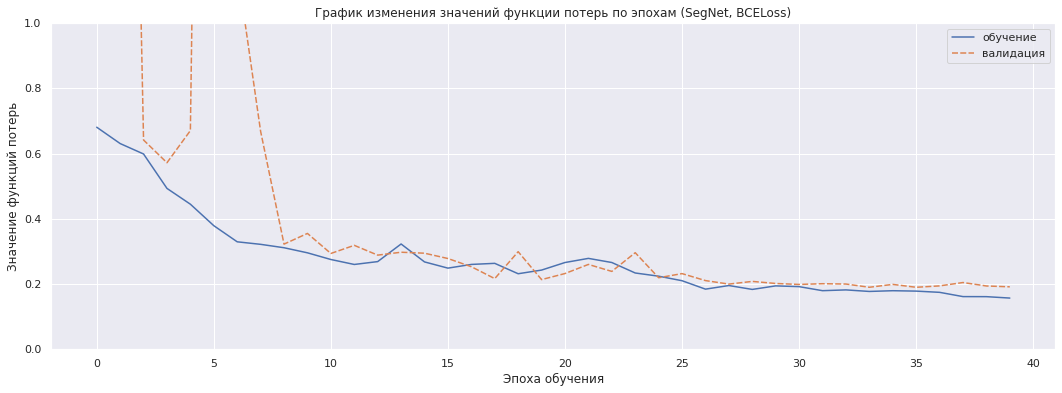

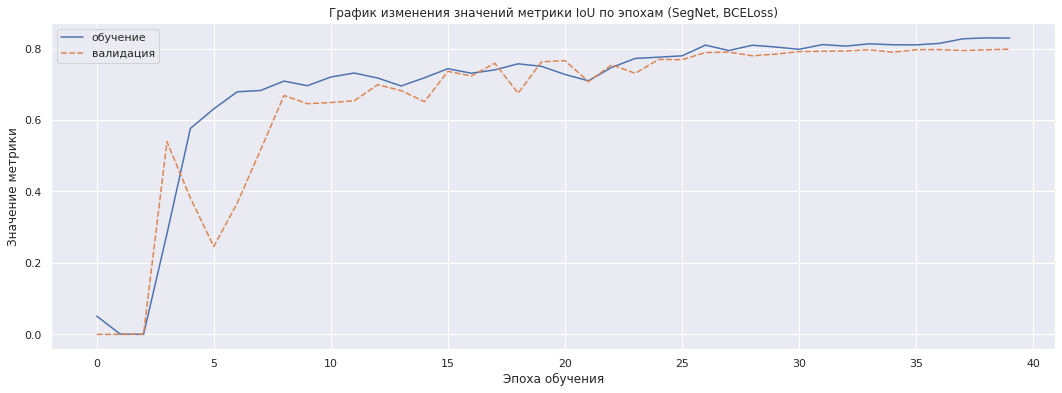

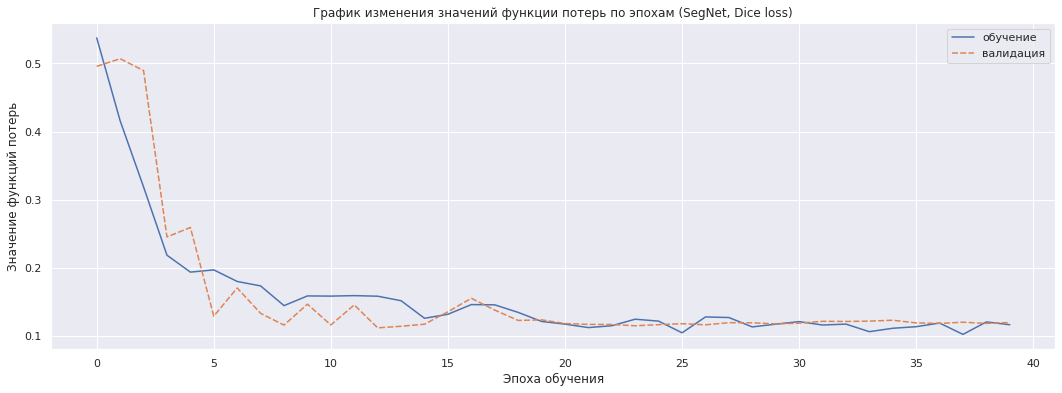

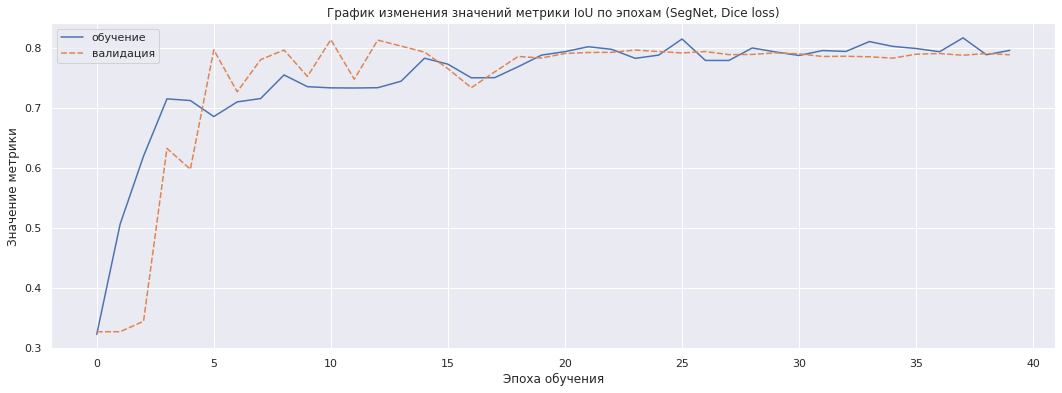

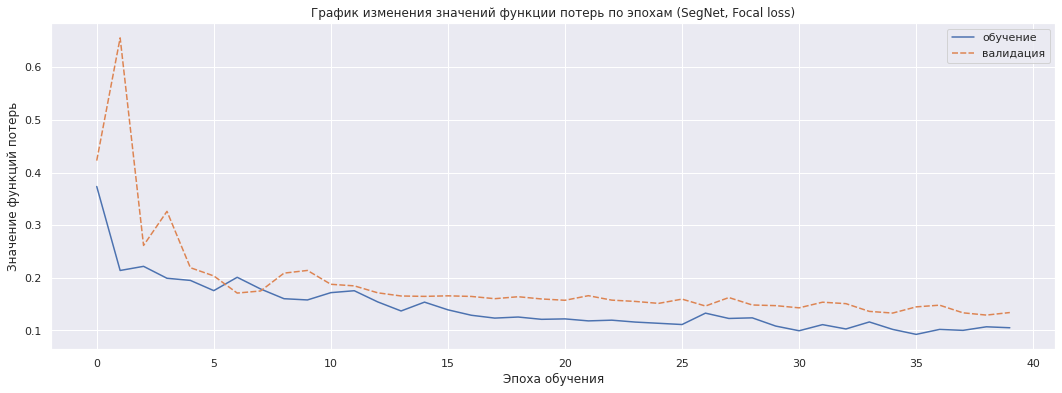

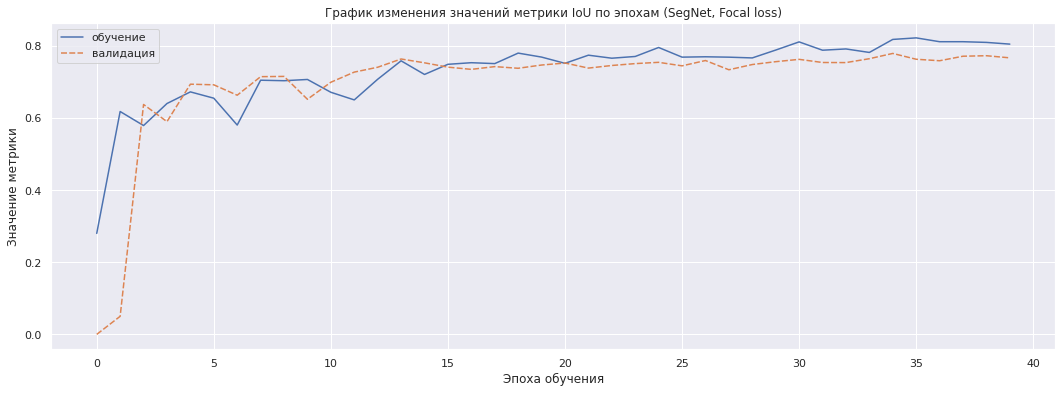

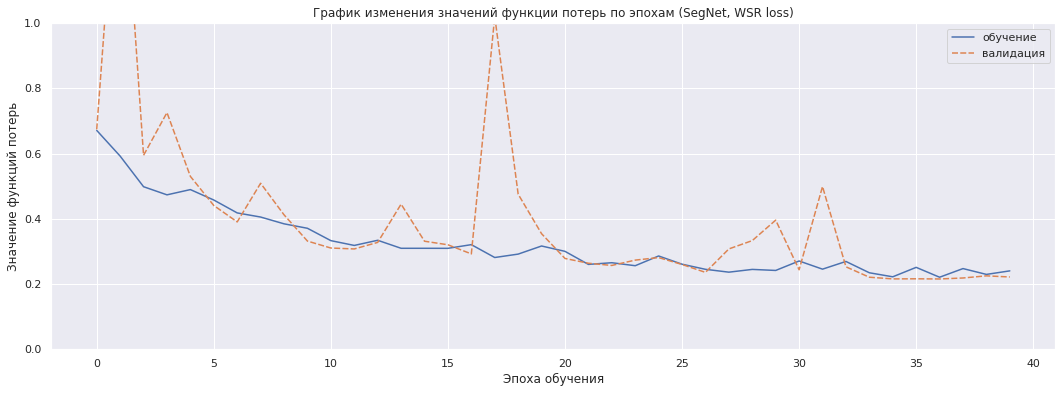

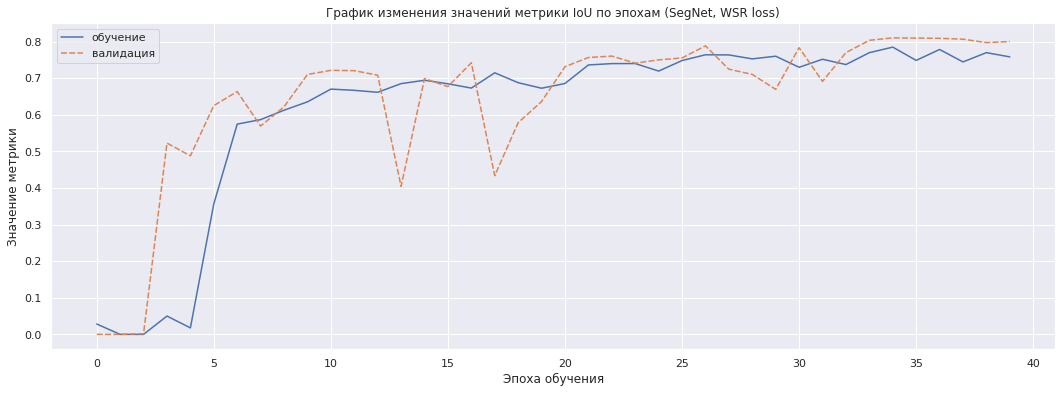

Из графиков видно, что 40 эпох хватило, чтобы достичь сходимости для всех функций потерь. При этом стоит отметить, что для функции потерь *Dice loss* значения на графиках сходились стабильнее всего.

Также мы обучили несколько моделей с различными вариациями архитектуры [*U-Net*](https://arxiv.org/abs/1505.04597). 

Первую модель мы реализовали в соответствии с оригинальной статьёй. Для пулинга (уменьшения размера изображений внутри сети) использовался _MaxPooling_, для апсамплинга (увеличения размера изображений внутри сети) - слои с обратной свёрткой _(ConvTranspose)_.

Во второй модели для пулинга также использовался _MaxPooling_, а для апсмаплинга был применён _nearest-neighbor Upsampling_.

В третьей модели для пулинга были применены свёрточные слои.

Все три модели обучались с функцией потерь BCE. Для каждой модели рассчитывался коэффициент _IoU_.

Сведём результаты экспериментов с U-Net в единую таблицу.

| Модель | Функция потерь | IoU (train) |IoU (valid) |
|---------|----|---|---|
| U-Net | BCE loss | 0.8668 |0.8016 |
| U-Net + upsampling | BCE loss | 0.8197 |0.8299 |
| U-Net + convpool | BCE loss | 0.7938 |0.8327 |

Видно, что в рамках наших экспериментов значения метрики _IoU_ для различных модификаций архитектуры _U-Net_ несколько выше, чем для модели _SegNet_. Наилучшего значения метрики на валидации удалось добиться при использовании свёрточного пуллинга.

Снова посмотрим на графики.

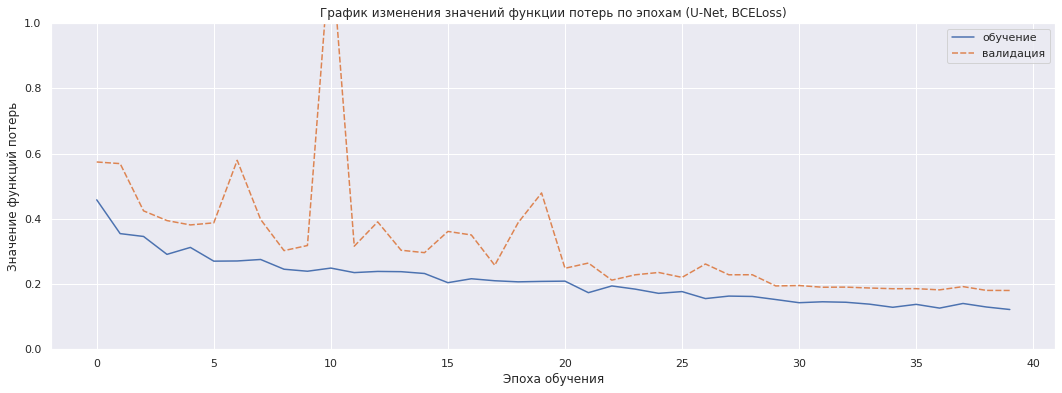

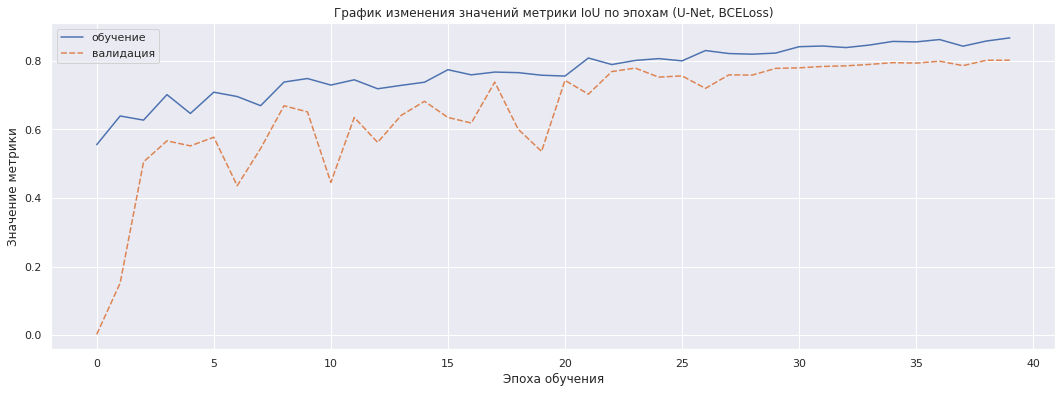

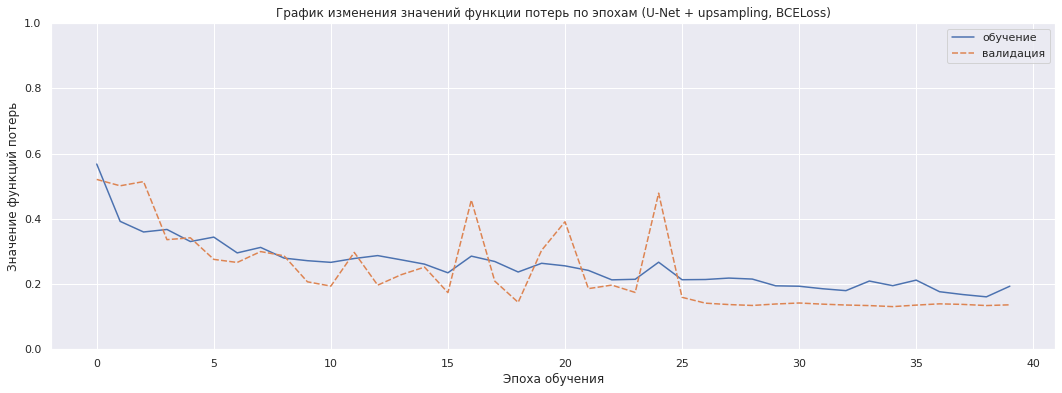

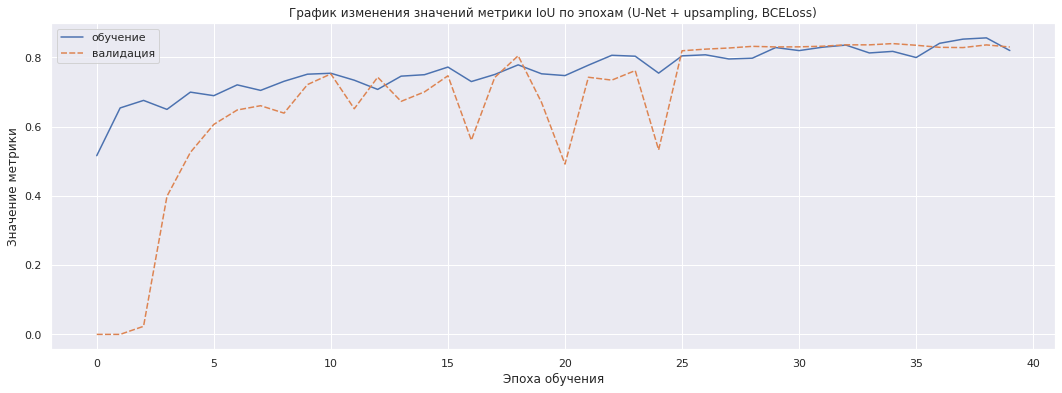

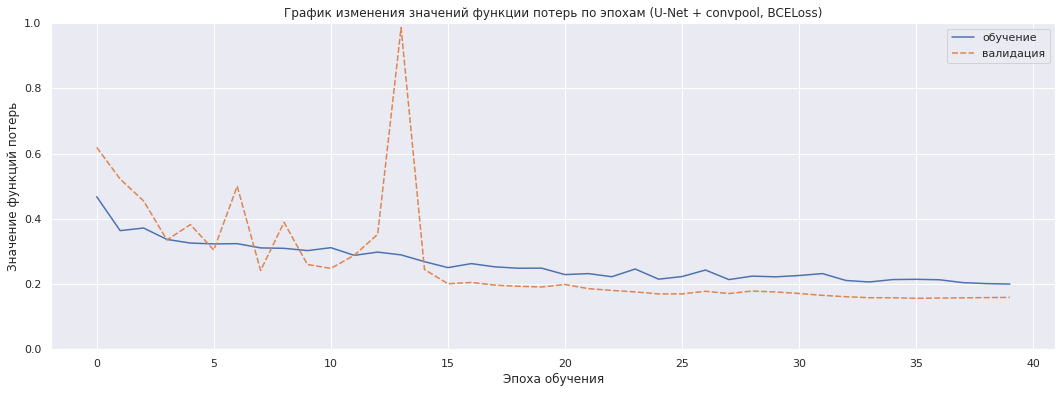

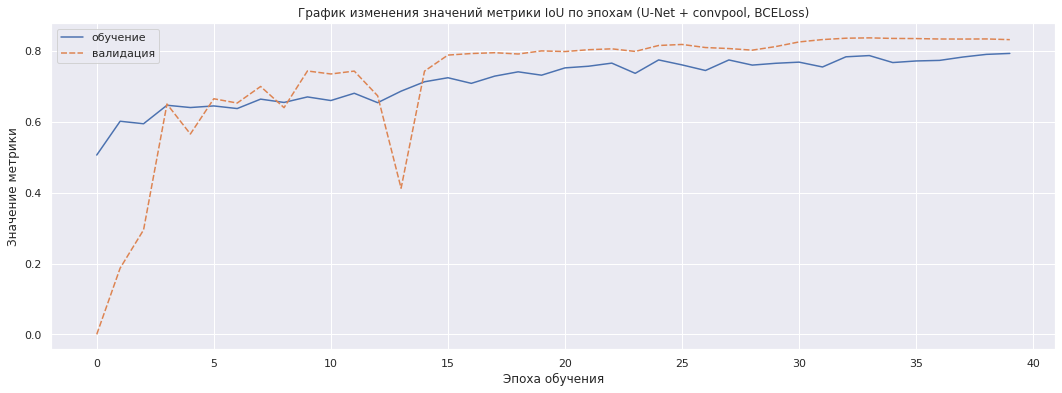

Видно, что хотя модели на основе U-Net показывают достаточно высокие значения метрики *IoU*, они сходятся несколько хуже моделей на основе архитектуры *SegNet*. Наилучшую сходимость показала модель со свёрточным пуллингом.

Из проведённых экспериментов видно, что на результаты модели оказывают существенное влияние различные факторы, в том числе выбор фукнции потерь и нюансов архитектуры. При их выборе следует учитывать несколько факторов: наилучшие значения метрики, стабильность сходимости модели, скорость обучения (количество обучаемых параметров модели). В рамках нашей задачи, если предположить, что заказчику важнее всего значение метрики *IoU*, наилучший результат продемонстрировала модель на основе архитектуры *U-Net* со свёрточным пуллингом.